In [1]:
%pylab inline
fontsize = 20
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy import interpolate
from numpy.fft import fft, ifft, fftfreq
from time import time

from tqdm import trange
from best_subset import *
from solvel0 import solvel0

from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.preprocessing import normalize as sk_normalize

from findiff import FinDiff
from abess.linear import LinearRegression
from UBIC import fit_blr, UBIC, decreasing_values_indices

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

In [3]:
# Set size of grid -> affect discovery results
n = 256
m = 256

# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T # shape = (len(x), len(t))

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

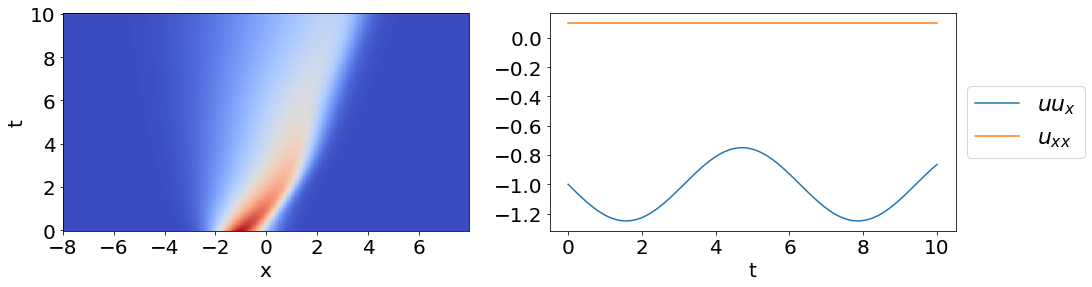

In [4]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
noise_lv = 10
noise_lv = abs(noise_lv)
u = u + 0.01*noise_lv*std(u)*np.random.randn(n, m)

if abs(noise_lv) > 0:
    print("Noisy", abs(noise_lv))
    # Build linear systems
    wx = 10 
    wt = 10 

    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'poly', 
                                               deg_x = 6, deg_t = 4, 
                                               width_x = wx, width_t = wt)
    n = n - 2*wx
    m = m - 2*wt
    
else:
    print("Noiseless")
    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')

Noisy 10


In [6]:
def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return Theta_grouped, Ut_grouped

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    # normalize 
    for i in range(m):
        As[i] = As[i].dot(np.diag(candidate_norms**-1))
        bs[i] = bs[i]/norm_bs[i]
        
    return As, bs

In [7]:
# m = len(t); n = len(x)
# Theta_grouped = [real(Theta[j*n:(j+1)*n,:]) for j in range(m)]
# Ut_grouped = [real(Ut[j*n:(j+1)*n]) for j in range(m)]

Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n, m), "temporal")

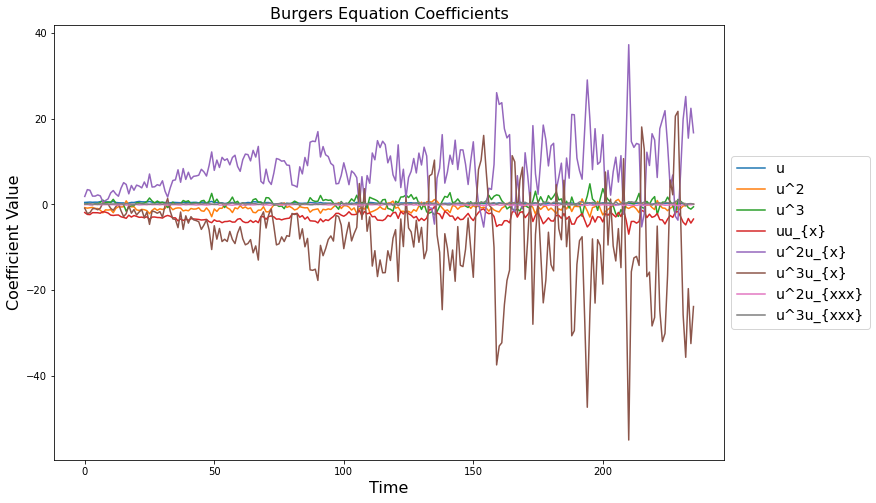

In [8]:
# sensitive to epsilon
# TrainSGTRidge -> not getting the optimal sol for each complexity > 2
# Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=0) # Failed!
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=2)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in np.where(np.linalg.norm(xi, axis=-1) > 1e-10)[0]:
    plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [9]:
n_domain = 1000
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x], 
                                 function_names=[lambda x: x], 
                                 derivative_order=2, p=4, 
                                 spatiotemporal_grid=np.asarray(np.meshgrid(x, t)).T, 
                                 include_bias=False, is_uniform=True, K=n_domain
                                )
X_weak  = weak_pde_lib.fit_transform(np.expand_dims(u, -1))
y_weak = weak_pde_lib.convert_u_dot_integral(np.expand_dims(u, -1))
bnb_gr_coeff = bnb(X_weak, y_weak, X_weak.shape[-1], corrected_coefficients=False)
set(solvel0(X_weak, y_weak, max_complexity=5, miosr=True, refine=True))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


{(0, 1, 2, 3), (0, 1, 2, 3, 4), (1, 2, 3), (2, 3), (3,)}

In [10]:
# maximal_complexity = Theta_grouped[0].shape[-1]
# bnb_candidates = set()
# for i in trange(len(Theta_grouped)):
#     # Parallelize this line to speed up the code
#     bnb_sols = bnb(Theta_grouped[i], Ut_grouped[i], maximal_complexity, corrected_coefficients=False)
#     for j in range(bnb_sols.shape[1]):
#         indices = tuple(np.nonzero(bnb_sols[:, j:j+1])[0])
#         if indices not in bnb_candidates:
#             bnb_candidates.add(indices)

In [11]:
Theta_grouped, Ut_grouped = [], []
n_domain = 1000
div = 16
max_complexity = len(weak_pde_lib.get_feature_names())
candidates = set()

for tsub in np.arange(0, len(t), div):
    print(tsub, '-->', tsub+div)
    weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x], 
                                     function_names=[lambda x: x], 
                                     derivative_order=2, p=4, 
                                     spatiotemporal_grid=np.asarray(np.meshgrid(x, t[tsub:tsub+div])).T, 
                                     include_bias=False, is_uniform=True, K=n_domain
                                    )
    
    X_weak  = weak_pde_lib.fit_transform(np.expand_dims(u[:, tsub:tsub+div], -1))
    y_weak = weak_pde_lib.convert_u_dot_integral(np.expand_dims(u[:, tsub:tsub+div], -1))
    
    Theta_grouped.append(X_weak)
    Ut_grouped.append(y_weak)
    
    # miosr (solvel0, ..., brute, ...)
    candidates = candidates.union(set(solvel0(X_weak, y_weak, max_complexity=max_complexity, 
                                              miosr=True, refine=True, verbose=False)))

0 --> 16
16 --> 32
32 --> 48
48 --> 64
64 --> 80
80 --> 96
96 --> 112
112 --> 128
128 --> 144
144 --> 160
160 --> 176
176 --> 192
192 --> 208
208 --> 224
224 --> 240
240 --> 256


#### Ranking parametric models

In [12]:
def ssr2llf(ssr, nobs):
    nobs2 = nobs / 2.0
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    ssr = np.sum(np.abs(ground - prediction)**2)
    return ssr2llf(ssr, nobs)

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def AIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # AIC
    rss = [np.linalg.norm(bs[j] - As[j].dot(x[:,j].reshape(D,1)))**2 for j in range(m)]
    rss = np.sum(rss)
    return N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)

# Sensitivity to epsilon was never discussed!
def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord=2)**2 
    # llf = ssr2llf(rss, N)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # N*np.log(2*np.pi*rss/N) + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

In [13]:
# IC on normalized data
unnorm_Theta_grouped, unnorm_Ut_grouped = Theta_grouped.copy(), Ut_grouped.copy()
Theta_grouped, Ut_grouped = normalize_groups(Theta_grouped, Ut_grouped, 2)

5


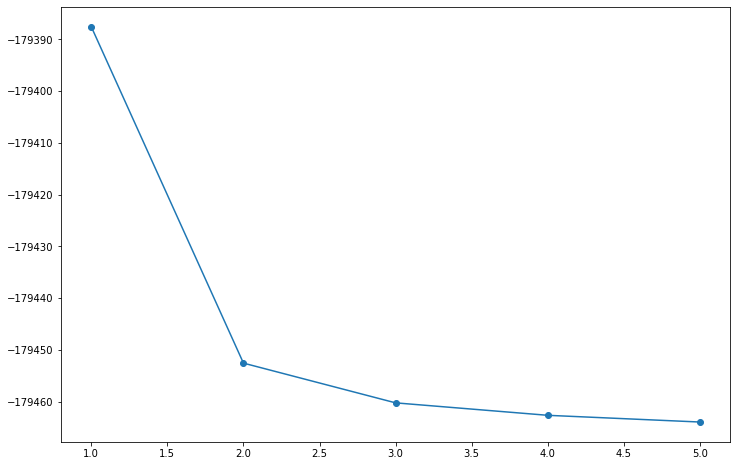

In [14]:
ic_scores = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
    aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]
print(complexities[np.argmin(aics)])
plt.plot(complexities, aics, '-o'); plt.show()

4


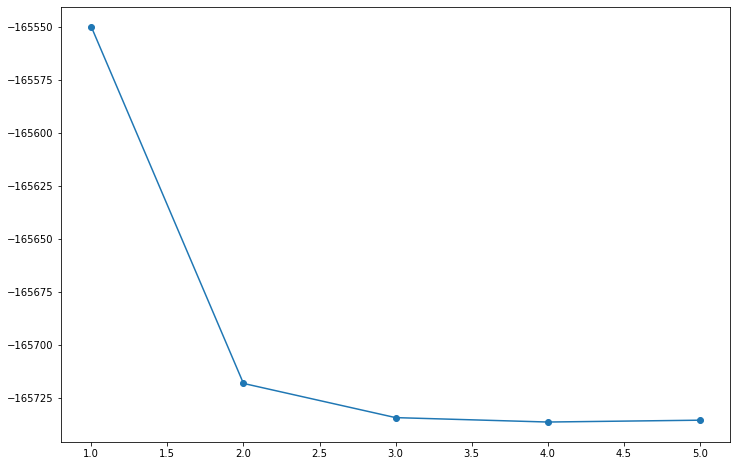

In [15]:
print(complexities[np.argmin(bics)])
plt.plot(complexities, bics, '-o'); plt.show()

epsilon 2.2073776356061243e-05
2
(2, 3)


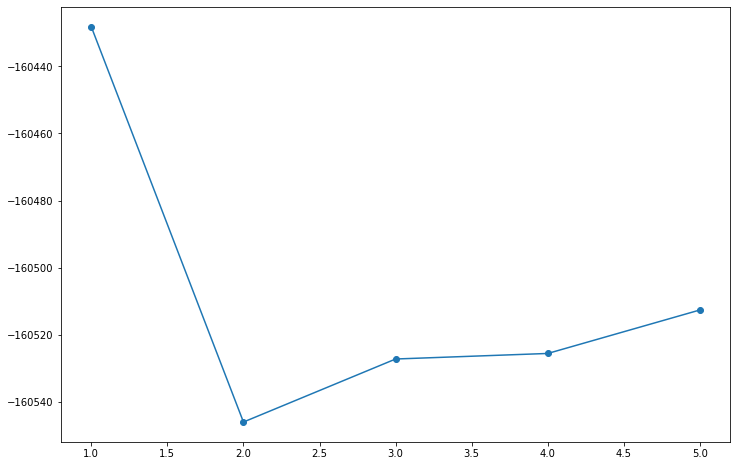

In [16]:
best_subsets = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    uncert = 0.0
    rss = 0.0
    for j in range(len(Theta_grouped)):
        # fit_brr
        # brr = BayesianRidge(fit_intercept=False)
        # brr.fit(Theta_grouped[j][:, indices], Ut_grouped[j].ravel())
        # post_mean, post_cov = brr.coef_.reshape(-1, 1), brr.sigma_
        post_mean, post_cov = fit_blr(Theta_grouped[j][:, indices], Ut_grouped[j])
        est_xi[indices, j:j+1] = post_mean
        uncert = uncert + np.sqrt(np.diag(post_cov)).sum()/abs(post_mean).sum()
        rss = rss + np.linalg.norm(Ut_grouped[j] - Theta_grouped[j].dot(est_xi[:, j:j+1]))**2
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)
        
nobs = Theta_grouped[0].shape[0]*len(Ut_grouped)
min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
epsilon = max(1e-5, 
              np.max([2*np.pi*best_subsets[com][0]/nobs for com in best_subsets]))
print("epsilon", epsilon)
complexities = sorted(best_subsets.keys())
bics = []
uncertainties = []
for com in complexities:
    rss, uncert, indices = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
    bics.append(rss2bic(rss, com+uncert, nobs, epsilon))
uncertainties = np.array(uncertainties)
best_indices = best_subsets[complexities[np.argmin(bics)]][-1]
print(complexities[np.argmin(bics)])
print(best_indices)
plt.plot(complexities, bics, '-o'); plt.show()

In [17]:
verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    rss, _, indices = best_subsets[com]
    assert com == len(indices)
    lower_bound = 2*ssr2llf(rss, nobs)/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
    
last_lam = np.log10(max(max(lower_bounds/uncertainties), 0))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = np.argmin(last_ubic)

thres = 1e-4
percent = 75
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))

while now_lam > 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]

    imp = np.nan
    if diff_com > 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))

    if verbose:
        print(last_bc, '--->', now_bc, np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam = round(last_lam, 10)
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
last_lam, last_ubic, last_bc, best_bc

0 ---> 0 inf
0 ---> 1 0.0007447030046770993
(2, 3) selected


(1.4019728256,
 array([-160193.62233955, -160270.53130316, -159578.17804958,
        -159564.68230358, -159317.69676984]),
 1,
 1)

In [18]:
# tune UBIC before ARDRegression
counter = {}
threshold_lambdas = [1e1, 1e2, 1e3, 1e4, 1e5]
for threshold_lambda in threshold_lambdas:
    coeff = np.zeros((unnorm_Theta_grouped[0].shape[-1], len(unnorm_Ut_grouped)))
    ard = ARDRegression(threshold_lambda=threshold_lambda, fit_intercept=False)
    for j in range(len(unnorm_Theta_grouped)): 
        ard.fit(unnorm_Theta_grouped[j][:, best_indices], unnorm_Ut_grouped[j].ravel())
        nonzero_indices = np.nonzero(ard.coef_)[0]
        if tuple(nonzero_indices) not in counter:
            counter[tuple(nonzero_indices)] = 1
        else:
            counter[tuple(nonzero_indices)] += 1
        coeff[np.array(best_indices)[nonzero_indices], j:j+1] = ard.coef_[nonzero_indices].reshape(-1 ,1)
best_indices = np.array(best_indices)[list((sorted(counter.items()))[0][0])]
counter, best_indices

({(1,): 26, (0, 1): 54}, array([2, 3]))

[[ 0.08938094  0.07458972  0.09808262  0.10982531  0.0788022   0.10352522
   0.12001386  0.12098124  0.12704881  0.12503713  0.13210521  0.05402006
   0.10800292  0.06827859 -0.00302917  0.12395691]
 [-1.08123043 -1.27139254 -1.34977281 -1.32871049 -0.95234994 -1.0903509
  -0.84973557 -0.90971232 -0.90667048 -1.01399644 -0.76087246 -1.15184609
  -1.544497   -1.06132638 -0.82717704 -0.70832215]]


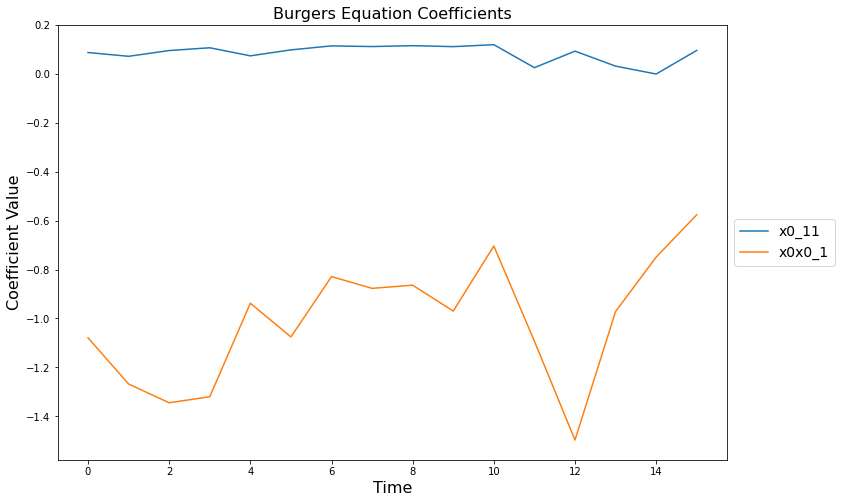

In [19]:
print(linear_fit_grouped_data((unnorm_Theta_grouped, unnorm_Ut_grouped), best_indices))
for efi in np.where(np.linalg.norm(coeff, axis=-1)>1e-10)[0]:
    plt.plot(coeff[efi, :], label=weak_pde_lib.get_feature_names()[efi])
title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

1


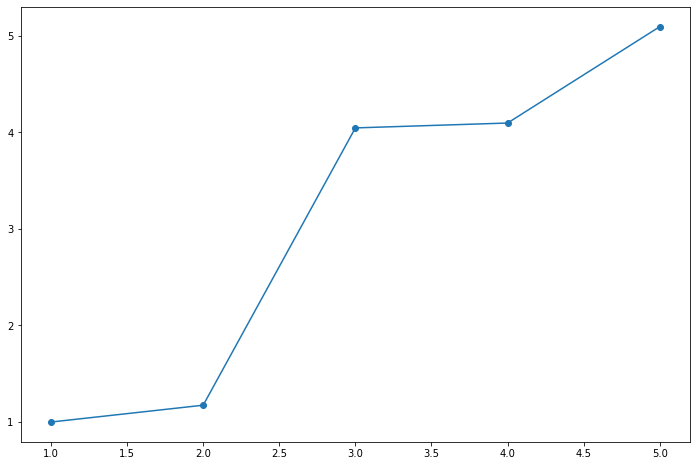

In [20]:
print(complexities[np.argmin(uncertainties)])
plt.plot(complexities, uncertainties, '-o'); plt.show()

(27.302665611582132, 14.22563748097011) 20.76415154627612


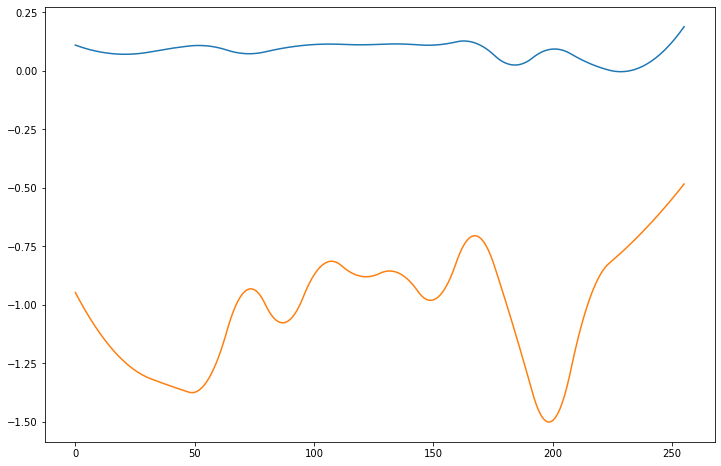

In [21]:
tnew = np.mean([t[tsub:tsub+div] for tsub in np.arange(0, len(t), div)], -1)
est_f1 = interpolate.interp1d(tnew, coeff[2], kind='quadratic', fill_value='extrapolate')
est_f2 = interpolate.interp1d(tnew, coeff[3], kind='quadratic', fill_value='extrapolate')
errors = coeff_error(est_f1(t), u_xx_true), coeff_error(est_f2(t), uu_x_true)
print(errors, np.mean(errors))
plt.plot(est_f1(t))
plt.plot(est_f2(t))
plt.show()

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
  0%|                                                                                                                        | 0/256 [00:00<?, ?it/s]/var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/ipykernel_7515/3287921382.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  est_xi = np.hstack([np.linalg.lstsq(np.hstack([f1[:, j:j+1], f2[:, j:j+1]]),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 13822.98it/s]


(100.0173061047262, 58.15917475150073) 79.08824042811347


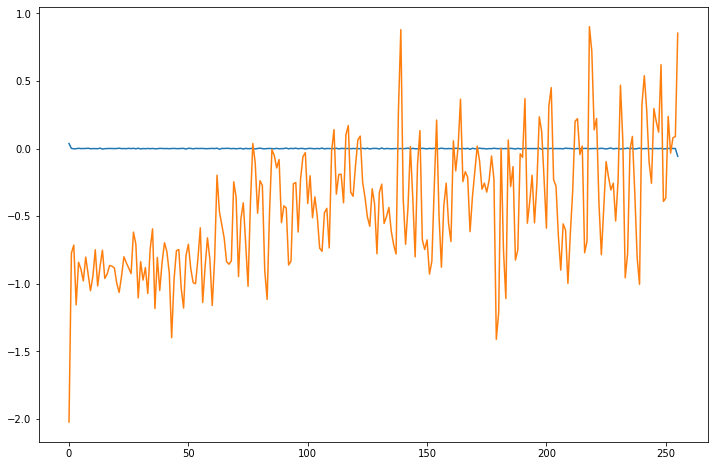

In [22]:
d_dt = FinDiff(1, dt, 1)
d_dx = FinDiff(0, dx, 1)
d_dxx = FinDiff(0, dx, 2)
f1 = d_dxx(u)
f2 = u*d_dx(u)
ft = d_dt(u)

est_xi = np.hstack([np.linalg.lstsq(np.hstack([f1[:, j:j+1], f2[:, j:j+1]]), 
                                    ft[:, j:j+1])[0] for j in trange(u.shape[-1])])
errors = coeff_error(est_xi[0], u_xx_true), coeff_error(est_xi[1], uu_x_true)
print(errors, np.mean(errors))
plt.plot(est_xi[0])
plt.plot(est_xi[1])
plt.show()